In [1]:
# ============= 1. 数据获取与预处理 =============
import opendatasets as od
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
import shap
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
import os
warnings.filterwarnings('ignore')

# 设置中文字体显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  

In [2]:
od.download("https://www.kaggle.com/datasets/aryan208/student-habits-and-academic-performance-dataset")
file =('student-habits-and-academic-performance-dataset/enhanced_student_habits_performance_dataset/enhanced_student_habits_performance_dataset.csv')
df= pd.read_csv(file)
df.head()
print(f"数据集形状: {df.shape}")
print("\n数据集描述性统计:")
display(df.describe(include='all'))

# 缺失值处理
print("\n缺失值统计:")
print(df.isnull().sum())

# 分类变量使用众数填充
categorical_cols = ['diet_quality', 'parental_education_level', 'study_environment', 'learning_style']
for col in categorical_cols:
    mode_val = df[col].mode()[0]
    df[col].fillna(mode_val, inplace=True)

# 数值变量使用中位数填充
numerical_cols = ['time_management_score', 'sleep_hours', 'attendance_percentage']
for col in numerical_cols:
    median_val = df[col].median()
    df[col].fillna(median_val, inplace=True)

print("\n处理后的缺失值统计：")
print(df.isnull().sum())

# 异常值处理
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 将异常值替换为边界值
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

# 处理数值特征的异常值
numerical_features = ['study_hours_per_day', 'social_media_hours', 'netflix_hours', 
                     'sleep_hours', 'exercise_frequency', 'social_activity',
                     'screen_time', 'attendance_percentage', 'previous_gpa',
                     'stress_level', 'motivation_level', 'exam_anxiety_score',
                     'time_management_score', 'exam_score']

for feature in numerical_features:
    df = handle_outliers(df, feature)

# 类型转换与编码
# 二元变量转换为0/1
binary_cols = ['part_time_job', 'extracurricular_participation', 
              'access_to_tutoring', 'dropout_risk']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# 分类变量编码
categorical_features = ['major', 'gender', 'study_environment', 'learning_style']
label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature])
    label_encoders[feature] = le

# 有序分类变量映射
diet_mapping = {'Poor': 1, 'Fair': 2, 'Good': 3}
internet_mapping = {'Low': 1, 'Medium': 2, 'High': 3}
family_income_mapping = {'Low': 1, 'Medium': 2, 'High': 3}
parental_edu_mapping = {
    'High School': 1, 
    'Some College': 2, 
    'Bachelor': 3,
    'Master': 4,
    'PhD': 5
}
df['diet_quality'] = df['diet_quality'].map(diet_mapping)
df['internet_quality'] = df['internet_quality'].map(internet_mapping)
df['family_income_range'] = df['family_income_range'].map(family_income_mapping)
df['parental_education_level'] = df['parental_education_level'].map(parental_edu_mapping)

Skipping, found downloaded files in ".\student-habits-and-academic-performance-dataset" (use force=True to force download)
数据集形状: (80000, 31)

数据集描述性统计:


,student_id,age,gender,major,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,...,screen_time,study_environment,access_to_tutoring,family_income_range,parental_support_level,motivation_level,exam_anxiety_score,learning_style,time_management_score,exam_score
count,80000.000000,80000.000000,80000,80000,80000.000000,80000.000000,80000.000000,80000,80000.000000,80000.000000,...,80000.000000,80000,80000,80000,80000.000000,80000.000000,80000.000000,80000,80000.000000,80000.000000
unique,NaN,NaN,3,6,NaN,NaN,NaN,2,NaN,NaN,...,NaN,5,2,3,NaN,NaN,NaN,4,NaN,NaN
top,NaN,NaN,Female,Arts,NaN,NaN,NaN,No,NaN,NaN,...,NaN,Dorm,No,Low,NaN,NaN,NaN,Kinesthetic,NaN,NaN
freq,NaN,NaN,26705,13505,NaN,NaN,NaN,40195,NaN,NaN,...,NaN,16119,40039,26720,NaN,NaN,NaN,20143,NaN,NaN
mean,139999.500000,22.004288,NaN,NaN,4.174388,2.501366,1.997754,NaN,69.967884,7.017417,...,9.673029,NaN,NaN,NaN,5.479438,5.488525,8.508475,NaN,5.499132,89.141350
std,23094.155105,3.745570,NaN,NaN,2.004135,1.445441,1.155992,NaN,17.333015,1.467377,...,2.780869,NaN,NaN,NaN,2.873327,2.867782,1.796411,NaN,2.603534,11.591497
min,100000.000000,16.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,40.000000,4.000000,...,0.300000,NaN,NaN,NaN,1.000000,1.000000,5.000000,NaN,1.000000,36.000000
25%,119999.750000,19.000000,NaN,NaN,2.800000,1.200000,1.000000,NaN,55.000000,6.000000,...,7.800000,NaN,NaN,NaN,3.000000,3.000000,7.000000,NaN,3.200000,82.000000
50%,139999.500000,22.000000,NaN,NaN,4.125624,2.500000,2.000000,NaN,69.900000,7.000000,...,9.700000,NaN,NaN,NaN,5.000000,5.000000,10.000000,NaN,5.500000,93.000000
75%,159999.250000,25.000000,NaN,NaN,5.500000,3.800000,3.000000,NaN,84.900000,8.000000,...,11.600000,NaN,NaN,NaN,8.000000,8.000000,10.000000,NaN,7.800000,100.000000



缺失值统计:
student_id                       0
age                              0
gender                           0
major                            0
study_hours_per_day              0
social_media_hours               0
netflix_hours                    0
part_time_job                    0
attendance_percentage            0
sleep_hours                      0
diet_quality                     0
exercise_frequency               0
parental_education_level         0
internet_quality                 0
mental_health_rating             0
extracurricular_participation    0
previous_gpa                     0
semester                         0
stress_level                     0
dropout_risk                     0
social_activity                  0
screen_time                      0
study_environment                0
access_to_tutoring               0
family_income_range              0
parental_support_level           0
motivation_level                 0
exam_anxiety_score               0
learning_sty

In [3]:
df['learning_focus_index'] = (
    df['study_hours_per_day'] * 
    (df['time_management_score'] / 10) *
    (df['internet_quality'] / 3)
)

df['digital_distraction_index'] = (
    (df['social_media_hours']**1.5 + df['netflix_hours']**1.5) / 
    (df['study_hours_per_day'] + 1)  # 相对于学习时间的比例
)
# 3. 健康平衡指数 - 基于自我决定理论
df['health_balance_index'] = (
    0.3 * np.log1p(df['sleep_hours']) +          # 睡眠收益递减
    0.2 * (df['diet_quality']**0.5) +           # 饮食质量平方根转换
    0.3 * np.tanh(df['exercise_frequency']/2) + # 运动饱和效应
    0.2 * df['mental_health_rating']/10
)
# 4. 学业压力指数-基于压力-成绩倒U型关系理论
def quadratic_stress_effect(stress, optimal=6, scale=0.5):
    return 10 * np.exp(-scale * (stress - optimal)**2)
df['academic_stress_index'] = quadratic_stress_effect(df['stress_level'])

# 5. 学习动机综合指数-基于期望价值理论
df['motivation_composite'] = (
    0.5 * (df['motivation_level'] / 10) +
    0.3 * (df['parental_support_level'] / 10) -
    0.2 * (df['exam_anxiety_score'] / 10)
)
# 6. 进步潜力-基于增长思维理论
df['gpa_growth_potential'] = (
    0.35 * (df['previous_gpa'] / 4.0) +
    0.35 * (df['attendance_percentage'] / 100) +
    0.3 * (df['time_management_score'] / 10)
)
# 7. 学习效率指数-基于认知心理学
df['learning_efficiency'] = (
    df['previous_gpa'] * 
    (df['time_management_score']/10) * 
    (df['learning_focus_index']/df['learning_focus_index'].max())
) / (df['study_hours_per_day'] + 1)

# 8. 学习韧性指数-应对挫折能力
df['academic_resilience'] = 0.6*df['motivation_level'] + 0.4*df['mental_health_rating'] - 0.3*df['exam_anxiety_score']

# 9. 动机与专注交互特征-
df['focus_motivation_interaction'] = df['learning_focus_index'] * df['motivation_composite']

# 10. 时间分配健康度 - 基于时间管理理论
# 理想比例：学习:娱乐:睡眠=4:3:3
ideal_ratio = np.array([0.4, 0.3, 0.3])
actual_ratio = np.column_stack([
    df['study_hours_per_day'] / 24,
    (df['social_media_hours'] + df['netflix_hours']) / 24,
    df['sleep_hours'] / 24
])
euclidean_dist = np.sqrt(np.sum((actual_ratio - ideal_ratio)**2, axis=1))
df['time_balance'] = 1 - euclidean_dist


In [4]:
# 选择特征和目标变量
X = df.drop(['student_id','previous_gpa', 'exam_score'], axis=1)
y = df['exam_score']

# 划分训练集和测试集 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"\n训练集大小: {X_train.shape}, 测试集大小: {X_test.shape}")


# 仅对训练集进行标准化
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), 
                             index=X_train.index,  # 保留原始索引
                             columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), 
                            index=X_test.index,  # 保留原始索引
                            columns=X_test.columns)

# 重置y的索引以确保与X对齐
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


训练集大小: (64000, 38), 测试集大小: (16000, 38)


In [5]:
# 基准模型集合 
models = {
    "梯度提升": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "随机森林": RandomForestRegressor(random_state=42),
    '决策树': DecisionTreeRegressor(max_depth=5, random_state=42),
}

# 训练并评估所有基准模型
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    pred = model.predict(X_test_scaled)
    
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    
    results[name] = {'RMSE': rmse, 'MAE': mae, 'R²': r2}
    print(f"{name} 性能:")
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    print("-" * 50)

梯度提升 性能:
RMSE: 5.5413, MAE: 4.5193, R²: 0.7698
--------------------------------------------------
XGBoost 性能:
RMSE: 4.4769, MAE: 3.4707, R²: 0.8498
--------------------------------------------------
随机森林 性能:
RMSE: 4.4288, MAE: 3.5189, R²: 0.8530
--------------------------------------------------
决策树 性能:
RMSE: 9.3807, MAE: 7.4644, R²: 0.3403
--------------------------------------------------


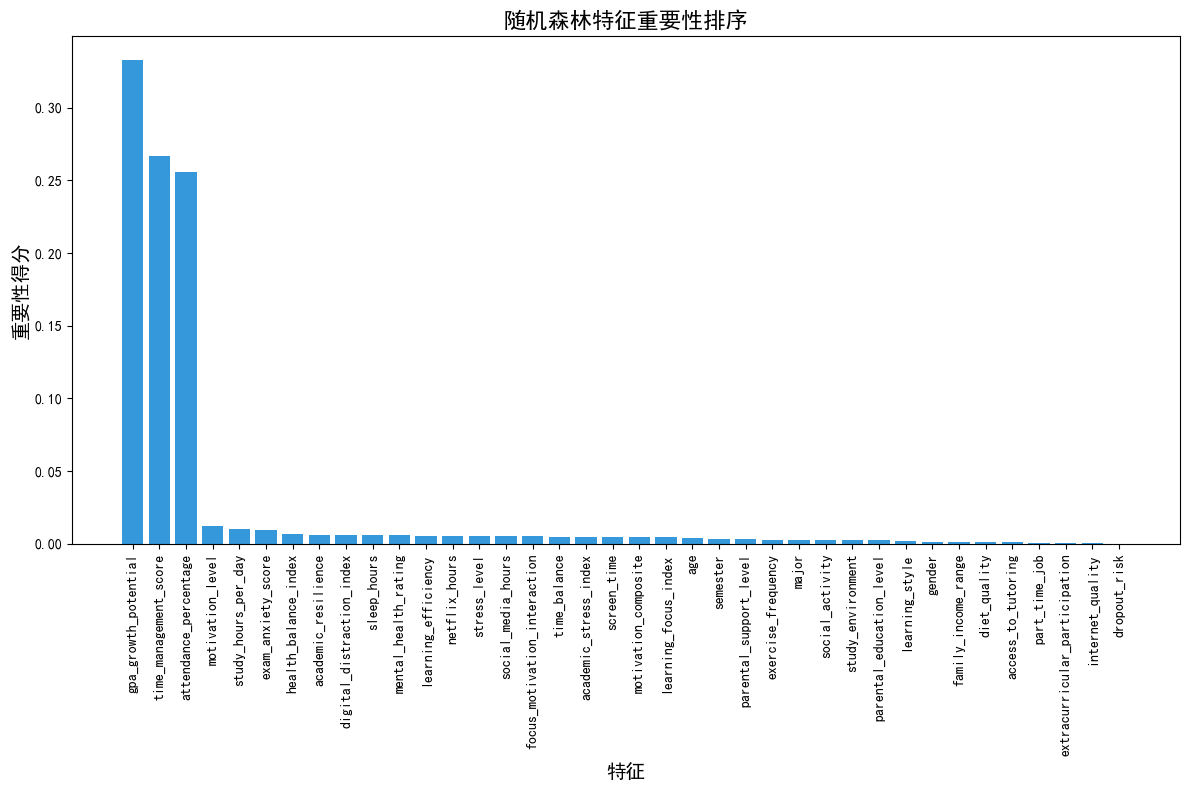

影响成绩的TOP 5关键特征: ['gpa_growth_potential', 'time_management_score', 'attendance_percentage', 'motivation_level', 'study_hours_per_day']


In [6]:
# 使用最佳模型（随机森林）进行特征重要性分析
rf_model = models["随机森林"]
importances = rf_model.feature_importances_
features = X_train_scaled.columns
indices = np.argsort(importances)[::-1]

# 可视化特征重要性
plt.figure(figsize=(12, 8))
plt.title("随机森林特征重要性排序", fontsize=16)
plt.bar(range(len(importances)), importances[indices], color='#3498db')
plt.xticks(range(len(importances)), features[indices], rotation=90)
plt.xlabel("特征", fontsize=14)
plt.ylabel("重要性得分", fontsize=14)
plt.tight_layout()
plt.show()

# 提取关键特征
top_features = features[indices][:5]
print(f"影响成绩的TOP 5关键特征: {list(top_features)}")

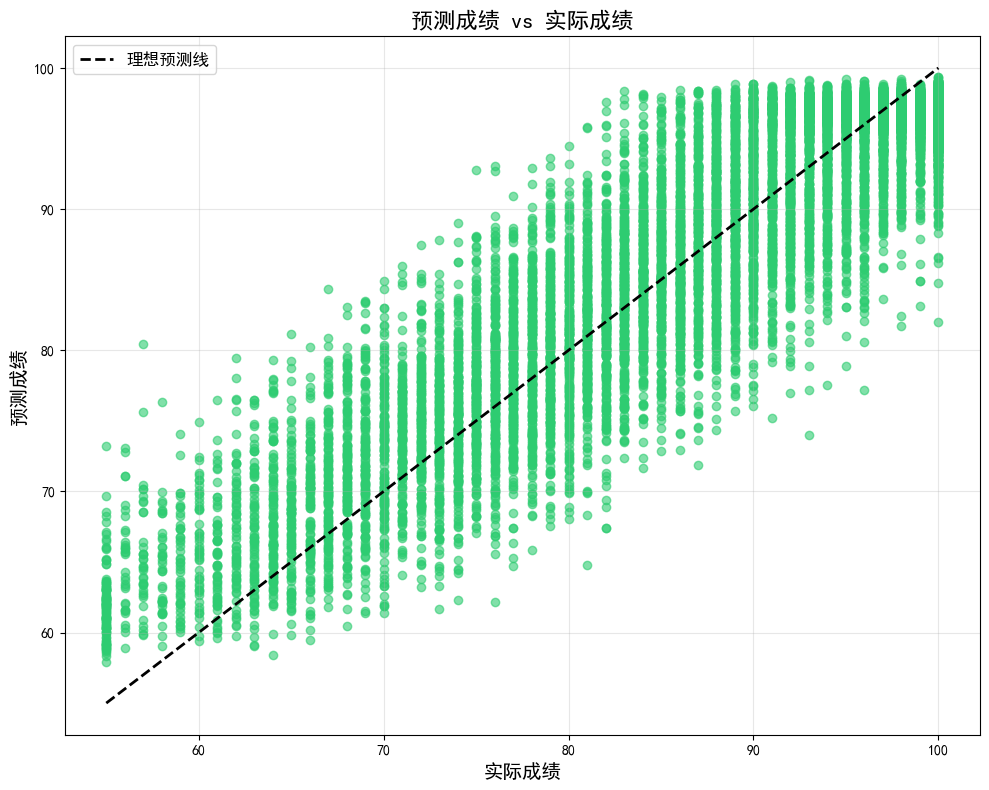

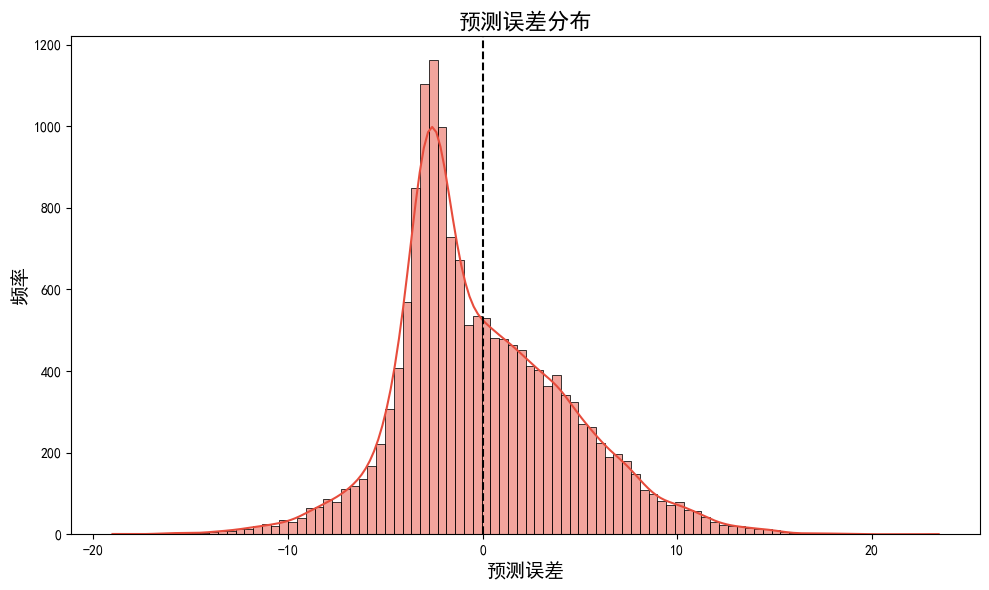

In [7]:
# 使用最佳模型进行预测
rf_pred = rf_model.predict(X_test_scaled)

# 可视化预测值与实际值对比
plt.figure(figsize=(10, 8))
plt.scatter(y_test, rf_pred, alpha=0.6, color='#2ecc71')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'k--', lw=2, label='理想预测线')
plt.title("预测成绩 vs 实际成绩", fontsize=16)
plt.xlabel("实际成绩", fontsize=14)
plt.ylabel("预测成绩", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 误差分布分析
errors = rf_pred - y_test
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, color='#e74c3c')
plt.title("预测误差分布", fontsize=16)
plt.xlabel("预测误差", fontsize=14)
plt.ylabel("频率", fontsize=14)
plt.axvline(x=0, color='k', linestyle='--')
plt.tight_layout()
plt.show()

需要干预的学生数量: 6366


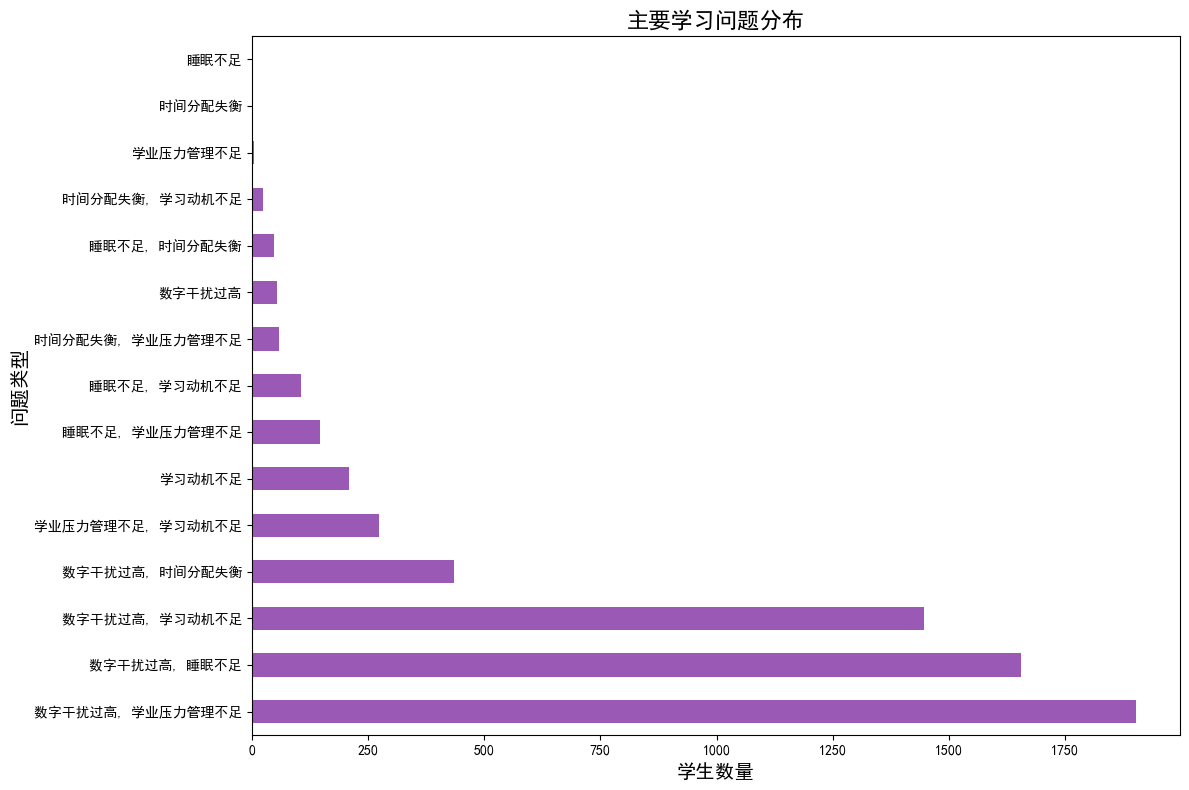

In [8]:
# 识别需要干预的学生群体
def identify_intervention_points(df):
    # 1. 识别成绩低于70分的学生
    low_performers = df[df['exam_score'] < 70].copy()
    
    # 2. 分析关键影响因素
    intervention_candidates = []
    for _, student in low_performers.iterrows():
        # 识别主要问题领域
        issues = []
        if student['digital_distraction_index'] > 0.7:
            issues.append("数字干扰过高")
        if student['sleep_hours'] < 6:
            issues.append("睡眠不足")
        if student['time_balance'] < 0.6:
            issues.append("时间分配失衡")
        if student['academic_stress_index'] < 5:
            issues.append("学业压力管理不足")
        if student['motivation_composite'] < 0.5:
            issues.append("学习动机不足")
        
        if issues:
            intervention_candidates.append({
                'student_id': student['student_id'],
                'exam_score': student['exam_score'],
                'main_issues': ", ".join(issues[:2]),
                'intervention_priority': len(issues)
            })
    
    return pd.DataFrame(intervention_candidates)

# 生成干预建议
intervention_df = identify_intervention_points(df)
print(f"需要干预的学生数量: {len(intervention_df)}")


# 可视化问题分布
if not intervention_df.empty:
    plt.figure(figsize=(12, 8))
    issue_counts = intervention_df['main_issues'].value_counts()
    issue_counts.plot(kind='barh', color='#9b59b6')
    plt.title("主要学习问题分布", fontsize=16)
    plt.xlabel("学生数量", fontsize=14)
    plt.ylabel("问题类型", fontsize=14)
    plt.tight_layout()

    plt.show()

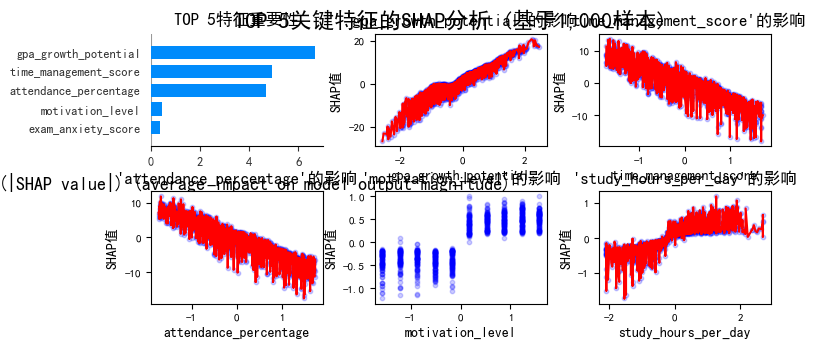

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import shap

plt.figure(figsize=(15, 10))

# 下采样测试集 (保留1000个样本)
sample_size = min(1000, X_test_scaled.shape[0])
sample_indices = np.random.choice(X_test_scaled.shape[0], sample_size, replace=False)
X_test_sampled = X_test_scaled.iloc[sample_indices]

# 计算采样后的SHAP值
explainer = shap.TreeExplainer(rf_model)
shap_values_sampled = explainer.shap_values(X_test_sampled)

# 创建2×3的子图布局
grid = plt.GridSpec(2, 3, wspace=0.3, hspace=0.4)

# 1. 特征重要性摘要图
ax1 = plt.subplot(grid[0, 0])
shap.summary_plot(shap_values_sampled, X_test_sampled, plot_type="bar", show=False, max_display=5)
ax1.set_title("TOP 5特征重要性", fontsize=12)
ax1.tick_params(labelsize=9)

# 2. 为每个TOP特征绘制依赖图 (加速版)
for i, feature in enumerate(top_features):
    ax = plt.subplot(grid[(i+1)//3, (i+1)%3])
    
    # 提取当前特征的SHAP值和特征值
    feat_idx = list(X_test_sampled.columns).index(feature)
    x = X_test_sampled.iloc[:, feat_idx]
    
    # 分类模型处理 (二分类取[1], 回归直接使用)
    shaps = shap_values_sampled[1][:, feat_idx] if isinstance(shap_values_sampled, list) else shap_values_sampled[:, feat_idx]
    
    # 快速散点图 + 平滑曲线
    ax.scatter(x, shaps, alpha=0.2, s=10, color='blue')
    
    # 添加局部平滑曲线
    from scipy.stats import gaussian_kde
    if len(np.unique(x)) > 20:  # 仅对连续特征平滑
        kde = gaussian_kde(np.vstack([x, shaps]))
        density = kde(np.vstack([x, shaps]))
        sorted_idx = np.argsort(x)
        ax.plot(x.iloc[sorted_idx], shaps[sorted_idx], 'r-', lw=1.5)
    
    ax.set_title(f"'{feature}'的影响", fontsize=12)
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel("SHAP值", fontsize=10)
    ax.tick_params(labelsize=8)

plt.suptitle("TOP 5关键特征的SHAP分析 (基于1,000样本)", fontsize=16, y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()